# Modeling and Performance (Part 2) 

Following the recommendation given in the summary of *modeling_and_performance_part1.ipynb*, in this notebook I explore possible model improvements considering the categories given by the feature COD_TIPO_NDG separately.

COD_TIPO_NDG divide the type of customers in three different categories:
1. **G**: Persona Giuridica
2. **F**: Persona Fisica
3. **C**: Cointestazione

These categories are expected to behave differently since they undertake different type of loans, are exposed to different type of risks and are driven by different idiosyncratic dynamics. For this reason it make sense to treat these categories separately and model their dynamics in dedicated models.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import os.path as path
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [2]:
df = pd.read_csv('sample_for_model.csv'
                  , parse_dates=['NUM_ANNO', 'NUM_YYYYMM', 'NUM_DATA_SOFFERENZA']
                  , dtype={'HAS_RECOVERED_12M': bool, 'HAS_RECOVERED_12M_AHEAD': bool})

In [3]:
pd.concat([
    df['COD_TIPO_NDG'].value_counts(),
    df['COD_TIPO_NDG'].value_counts(normalize=True)
], axis=1)

,COD_TIPO_NDG,COD_TIPO_NDG
G,212610,0.438604
F,162882,0.336017
C,109251,0.225379


The different customers types are well balanced in the avalable datasample.

## Check correlations by Type of Customers
As done previously, I use Pearson's correlation coeafficients to evaluate features's predictive power with respect to the target variable. In this case, the correlations are calculated for the entire dataset (as done previously) as well as separating the different type of customers.

The same criteria is used to select relevant features, i.e. correlation coefficient > 5%.

In [4]:
cols=['FILIALE', 
      'NUM_DATA_SOFFERENZA', 
      'IMP_GBV', 
      'IMP_INCASSI', 
      'IMP_CUSUM_INCASSI',
      'MAX_IMP_GBV', 
      'RECOVERY_RATE_TOTAL', 
      'NUM_MONTHS_SOFFERENZA',
      'Contabile linea capitale', 
      'Contabile linea interessi di mora',
      'Credito vantato', 
      'IMP_ACCRDT', 
      'IMP_UTLZT', 
      'IMP_VAL_GAR',
      'IMP_GARNTT', 
      'IMP_SCONFNM', 
      'IMP_MARGN_UTLZ', 
      'NUM_ENTI_SEGNALANTI',
      'NUM_COMPONENTI_COINTESTAZIONE', 
      'NUM_ID_RAPPORTO', 
      'NUM_ID_GARANTE',
      'IMP_GAR', 
      'IMP_INCASSI_ROLLING_12M',
      'HAS_RECOVERED_12M', 
      'RECOVERY_RATE_12M',
      'IMP_INCASSI_ROLLING_12M_AHEAD', 
      'HAS_RECOVERED_12M_AHEAD',
      'RECOVERY_RATE_12M_AHEAD'
     ]

tmp=df.loc[~df['HAS_RECOVERED_12M_AHEAD'].isna()].copy()
tmp['HAS_RECOVERED_12M_AHEAD']=tmp['HAS_RECOVERED_12M_AHEAD'].astype(bool)

corr_t = tmp.loc[(~tmp['HAS_RECOVERED_12M_AHEAD'].isna()), cols].corr()
corr_g = tmp.loc[(~tmp['HAS_RECOVERED_12M_AHEAD'].isna())&(tmp['COD_TIPO_NDG']=='G'), cols].corr()
corr_f = tmp.loc[(~tmp['HAS_RECOVERED_12M_AHEAD'].isna())&(tmp['COD_TIPO_NDG']=='F'), cols].corr()
corr_c = tmp.loc[(~tmp['HAS_RECOVERED_12M_AHEAD'].isna())&(tmp['COD_TIPO_NDG']=='C'), cols].corr()

c=pd.concat([
    corr_t['HAS_RECOVERED_12M_AHEAD']
    ,corr_g['HAS_RECOVERED_12M_AHEAD']
    ,corr_f['HAS_RECOVERED_12M_AHEAD']
    ,corr_c['HAS_RECOVERED_12M_AHEAD']
], axis=1, keys=['Total', 'Persona Giuridica','Persona Fisica', 'Cointestazione'])

In [5]:
display(c)

,Total,Persona Giuridica,Persona Fisica,Cointestazione
FILIALE,0.118062,0.064657,0.144507,0.110877
IMP_GBV,0.074235,0.057180,0.125322,0.007360
IMP_INCASSI,0.036884,0.041403,0.036002,0.030388
IMP_CUSUM_INCASSI,0.064372,0.068085,0.073612,0.048743
MAX_IMP_GBV,0.065924,0.050340,0.119765,-0.000070
RECOVERY_RATE_TOTAL,0.060487,0.044504,0.106600,0.094702
NUM_MONTHS_SOFFERENZA,-0.125404,-0.130560,-0.122240,-0.069148
Contabile linea capitale,0.045636,0.000834,0.050409,0.054487
Contabile linea interessi di mora,0.073338,0.062953,0.066236,0.064267
Credito vantato,0.070276,0.031845,0.068144,0.065962


In [6]:
c.abs() > 0.05

,Total,Persona Giuridica,Persona Fisica,Cointestazione
FILIALE,True,True,True,True
IMP_GBV,True,True,True,False
IMP_INCASSI,False,False,False,False
IMP_CUSUM_INCASSI,True,True,True,False
MAX_IMP_GBV,True,True,True,False
RECOVERY_RATE_TOTAL,True,False,True,True
NUM_MONTHS_SOFFERENZA,True,True,True,True
Contabile linea capitale,False,False,True,True
Contabile linea interessi di mora,True,True,True,True
Credito vantato,True,False,True,True


As shown above, the 5% criteria on the correlation coefficients provides the same set of features as selected in the complete dataset for *Persona Giuridica* and *Cointestazione*.

As regard *Persona Fisica*, in addition to the same set of features, the 'IMP_GAR' must be considere since its correlation coefficient is ~11%.

This interesting observation suggest to separate the dataset on COD_TIPO_NDG and test separate models.

Since Random Forest is found to be the best model for both the classification and the regression tasks, only this model will be considered here.

# Prepare the separated dataset

In [7]:
numerical_cols=[
    'IMP_GBV',
    'IMP_CUSUM_INCASSI',
    'MAX_IMP_GBV',
    'RECOVERY_RATE_TOTAL',
    'NUM_MONTHS_SOFFERENZA',
    'Contabile linea interessi di mora',
    'Credito vantato',
    'NUM_ENTI_SEGNALANTI',
    'NUM_COMPONENTI_COINTESTAZIONE',
    'NUM_ID_RAPPORTO',
    'NUM_ID_GARANTE',
    'IMP_INCASSI_ROLLING_12M',
    'IMP_GAR'
]

target_classifier = 'HAS_RECOVERED_12M_AHEAD'
target_regressor = 'RECOVERY_RATE_12M_AHEAD'

In [8]:
# Train/Test sample: entry with a 12 month ahead horizon
sample_train_test=df.loc[(~df['HAS_RECOVERED_12M_AHEAD'].isna())]

In [9]:
sample_train_test.shape

(218367, 46)

In [10]:
from classifier_utils import *

In [11]:
X_F = sample_train_test.loc[sample_train_test['COD_TIPO_NDG']=='F', numerical_cols].reset_index(drop=True)
y_F = sample_train_test.loc[sample_train_test['COD_TIPO_NDG']=='F', [target_classifier, target_regressor]].reset_index(drop=True)

X_C = sample_train_test.loc[sample_train_test['COD_TIPO_NDG']=='C', numerical_cols].reset_index(drop=True)
y_C = sample_train_test.loc[sample_train_test['COD_TIPO_NDG']=='C', [target_classifier, target_regressor]].reset_index(drop=True)
X_C.drop(columns='IMP_GAR', inplace=True) # Remove 'IMP_GAR' for C

X_G = sample_train_test.loc[sample_train_test['COD_TIPO_NDG']=='G', numerical_cols].reset_index(drop=True)
y_G = sample_train_test.loc[sample_train_test['COD_TIPO_NDG']=='G', [target_classifier, target_regressor]].reset_index(drop=True)
X_G.drop(columns='IMP_GAR', inplace=True) # Remove 'IMP_GAR' for G


# Train model for Persona Fisica only

In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_F, y_F, test_size=0.2, random_state=123)

y_train_classifier = y_train[target_classifier].astype(bool)
y_test_classifier = y_test[target_classifier].astype(bool)

y_train_regressor = y_train[target_regressor].astype(float)
y_test_regressor = y_test[target_regressor].astype(float)

In [13]:
y_train = y_train_classifier
y_test = y_test_classifier

In [14]:
print('Train shape: ', X_train.shape)
print('Test shape: ', X_test.shape)

Train shape:  (58988, 13)
Test shape:  (14748, 13)


## Classifier

In [15]:
%%time

from sklearn.ensemble import RandomForestClassifier

model=train_model('classifier_random_forest_pf'
            , model = RandomForestClassifier(n_estimators=500, min_samples_split=2, min_samples_leaf=2, n_jobs=-1, random_state=0, class_weight='balanced_subsample')
            , X=X_train, y=y_train
            , categorical_features=[]
            , pca_n_components=0
            , save=True)

Save model to: classifier_random_forest_pf_20191105.joblib
CPU times: user 1min, sys: 941 ms, total: 1min 1s
Wall time: 1min 19s


In [16]:
# Performance on 1 split
from sklearn.metrics import classification_report
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.99      0.99      0.99     12687
        True       0.93      0.93      0.93      2061

    accuracy                           0.98     14748
   macro avg       0.96      0.96      0.96     14748
weighted avg       0.98      0.98      0.98     14748



In [17]:
# Cross validation
cross_validate_model(model, X_train, y_train, cv=3)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.0min finished


,F1,Precision,Recall,Roc auc
error,0.001805,0.003907,0.004197,0.000892
value,0.886295,0.908560,0.865124,0.987193


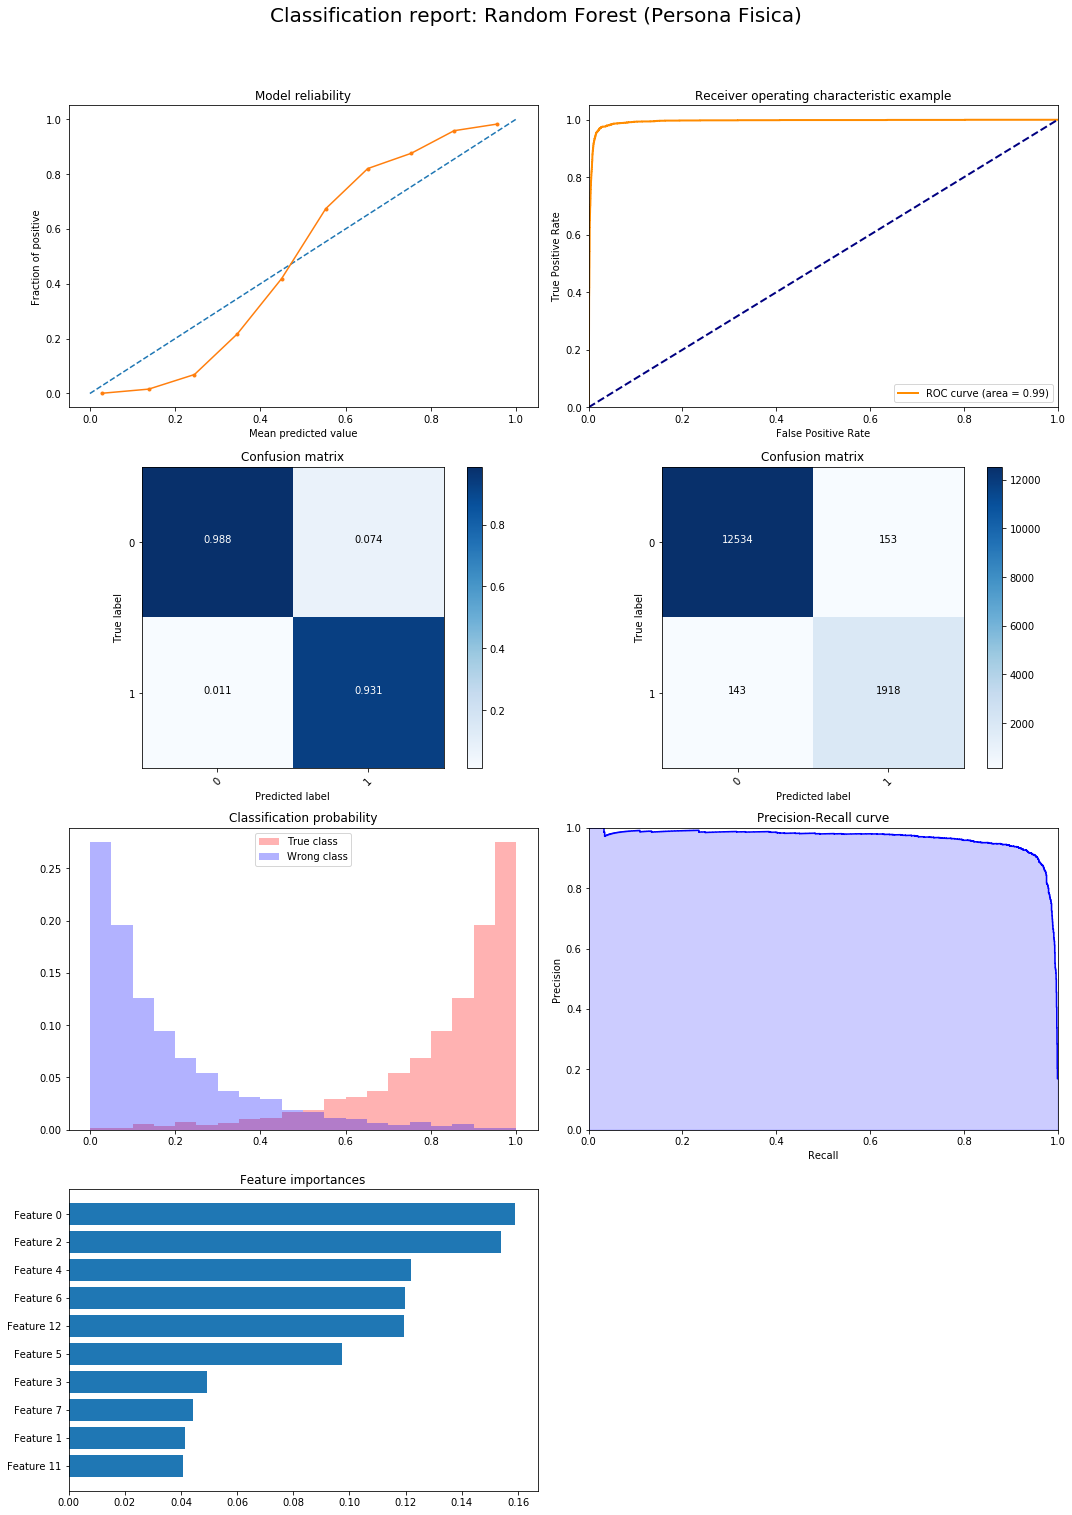

In [18]:
plot_report('Random Forest (Persona Fisica)', model, X_test, y_test)

## Regressor

In [19]:
%%time
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=500, min_samples_split=2, min_samples_leaf=2, n_jobs=-1, random_state=0,)

model=train_model('regressor_random_forest_pf'
            , model = model
            , X=X_train, y=y_train_regressor
            , save=True)

Save model to: regressor_random_forest_pf_20191105.joblib
CPU times: user 3min 6s, sys: 973 ms, total: 3min 7s
Wall time: 1min 43s


In [20]:
print('R2 on test sample: %.3f' % model.score(X_test, y_test_regressor))
y_pred = model.predict(X_test)
print('MSE on test sample: %.3f' % mean_squared_error(y_test_regressor, y_pred))

R2 on test sample: 0.801
MSE on test sample: 0.003


In [21]:
cross_validate_model(model, X_train,y_train_regressor, cv=3,
                     scoring=['r2', 'neg_mean_squared_error'])

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  2.6min finished


,Neg mean squared error,R2
error,0.000381,0.009804
value,-0.004693,0.685307


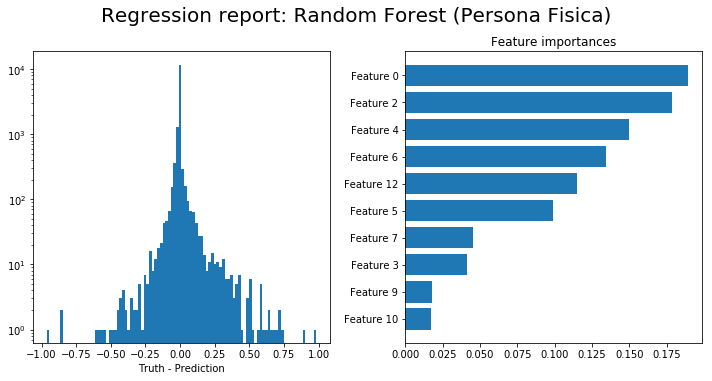

In [22]:
reg_plot_report('Random Forest (Persona Fisica)', model, X_test,y_test_regressor)

#  Train model for Cointestazione only

In [23]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_C, y_C, test_size=0.2, random_state=123)

y_train_classifier = y_train[target_classifier].astype(bool)
y_test_classifier = y_test[target_classifier].astype(bool)

y_train_regressor = y_train[target_regressor].astype(float)
y_test_regressor = y_test[target_regressor].astype(float)

In [24]:
print('Train shape: ', X_train.shape)
print('Test shape: ', X_test.shape)

Train shape:  (34692, 12)
Test shape:  (8673, 12)


## Classifier

In [25]:
%%time

from sklearn.ensemble import RandomForestClassifier

model=train_model('classifier_random_forest_c'
            , model = RandomForestClassifier(n_estimators=500, min_samples_split=2, min_samples_leaf=2, n_jobs=-1, random_state=0, class_weight='balanced_subsample')
            , X=X_train, y=y_train_classifier
            , categorical_features=[]
            , pca_n_components=0
            , save=True)

Save model to: classifier_random_forest_c_20191105.joblib
CPU times: user 33.2 s, sys: 570 ms, total: 33.7 s
Wall time: 19.1 s


In [26]:
# Performance on 1 split
from sklearn.metrics import classification_report
y_pred = model.predict(X_test)
print(classification_report(y_test_classifier, y_pred))

              precision    recall  f1-score   support

       False       0.97      0.98      0.98      6988
        True       0.93      0.88      0.90      1685

    accuracy                           0.96      8673
   macro avg       0.95      0.93      0.94      8673
weighted avg       0.96      0.96      0.96      8673



In [27]:
# Cross validation
cross_validate_model(model, X_train, y_train_classifier, cv=3)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   29.9s finished


,F1,Precision,Recall,Roc auc
error,0.005083,0.008715,0.003216,0.000978
value,0.852096,0.895748,0.812528,0.973354


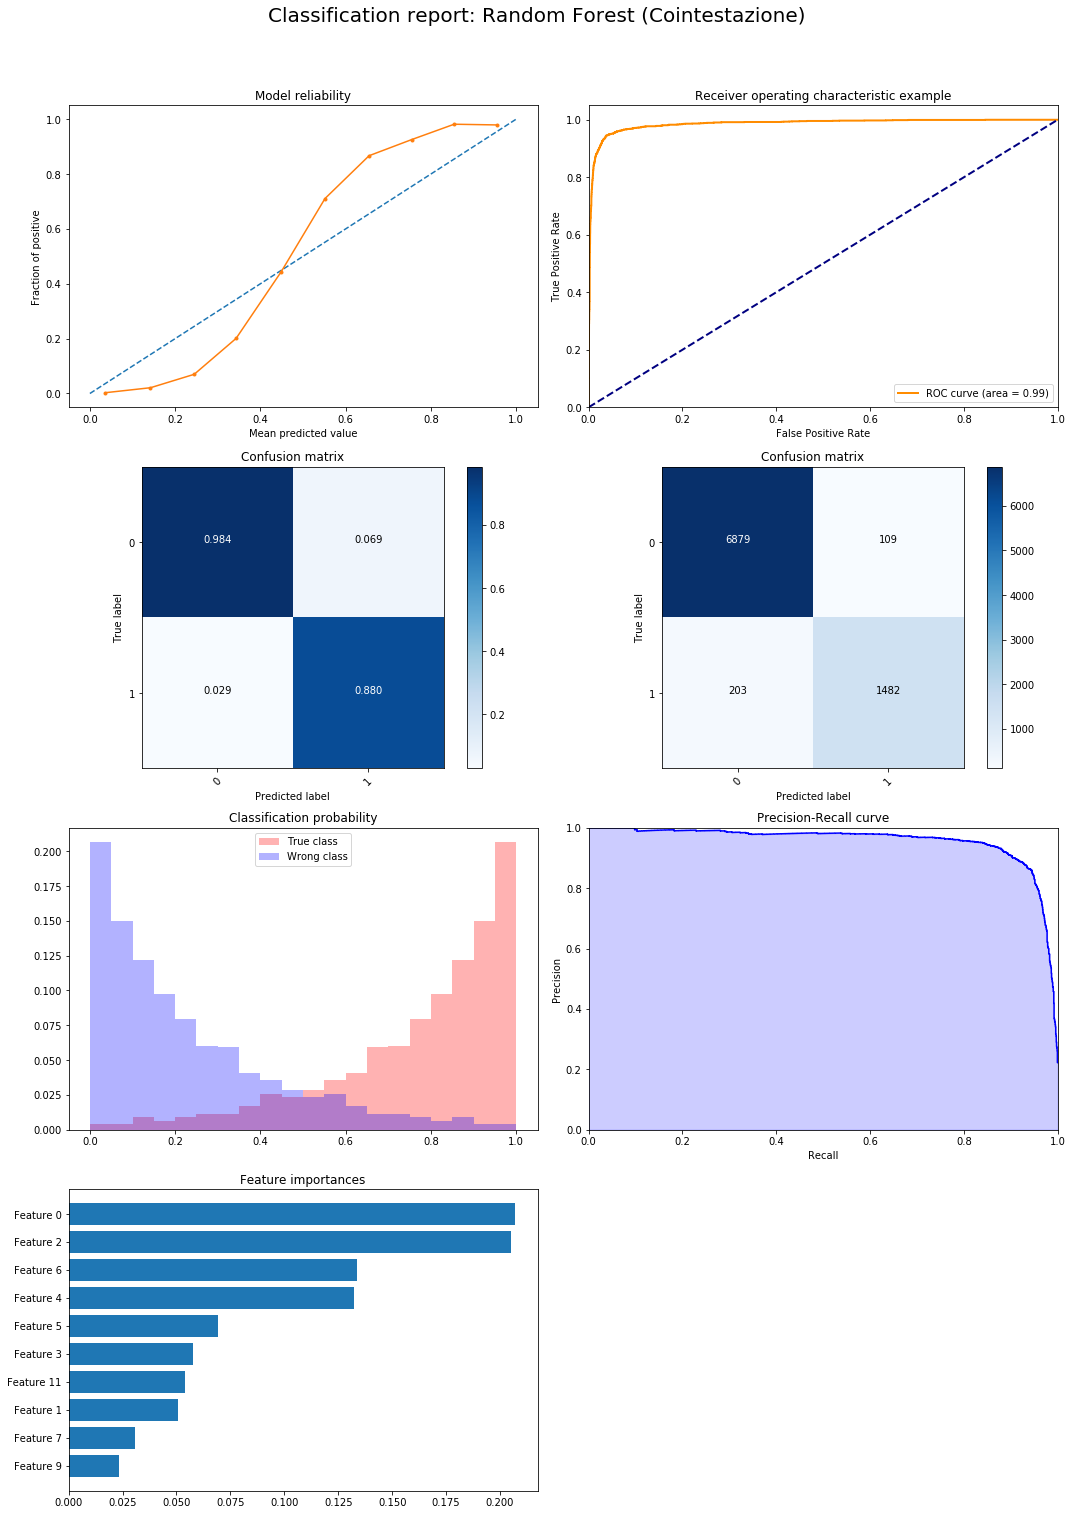

In [28]:
plot_report('Random Forest (Cointestazione)', model, X_test, y_test_classifier)

## Regressor

In [29]:
%%time
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=500, min_samples_split=2, min_samples_leaf=2, n_jobs=-1, random_state=0,)

model=train_model('regressor_random_forest_c'
            , model = model
            , X=X_train, y=y_train_regressor
            , save=True)

Save model to: regressor_random_forest_c_20191105.joblib
CPU times: user 1min 26s, sys: 768 ms, total: 1min 27s
Wall time: 54 s


In [30]:
print('R2 on test sample: %.3f' % model.score(X_test, y_test_regressor))
y_pred = model.predict(X_test)
print('MSE on test sample: %.3f' % mean_squared_error(y_test_regressor, y_pred))

R2 on test sample: 0.784
MSE on test sample: 0.004


In [31]:
cross_validate_model(model, X_train,y_train_regressor, cv=3,
                     scoring=['r2', 'neg_mean_squared_error'])

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.2min finished


,Neg mean squared error,R2
error,0.000097,0.013088
value,-0.006471,0.645897


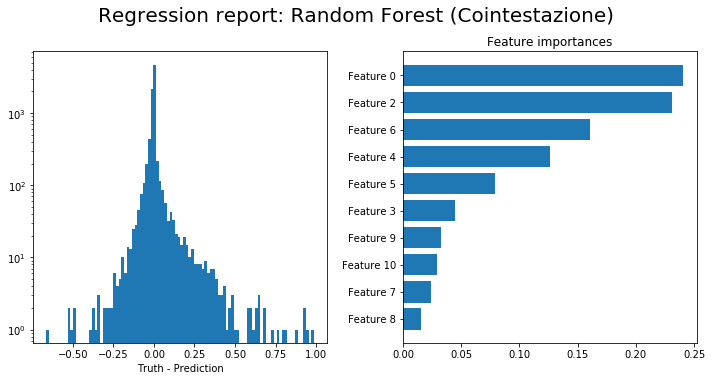

In [32]:
reg_plot_report('Random Forest (Cointestazione)', model, X_test, y_test_regressor)

# Train model for Persona Giuridica only

In [47]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_G, y_G, test_size=0.2, random_state=123)

y_train_classifier = y_train[target_classifier].astype(bool)
y_test_classifier = y_test[target_classifier].astype(bool)

y_train_regressor = y_train[target_regressor].astype(float)
y_test_regressor = y_test[target_regressor].astype(float)

In [48]:
print('Train shape: ', X_train.shape)
print('Test shape: ', X_test.shape)

Train shape:  (81012, 12)
Test shape:  (20254, 12)


## Classifier

In [49]:
%%time

from sklearn.ensemble import RandomForestClassifier

model=train_model('classifier_random_forest_pg'
            , model = RandomForestClassifier(n_estimators=500, min_samples_split=2, min_samples_leaf=2, n_jobs=-1, random_state=0, class_weight='balanced_subsample')
            , X=X_train, y=y_train_classifier
            , categorical_features=[]
            , pca_n_components=0
            , save=True)

Save model to: classifier_random_forest_pg_20191105.joblib
CPU times: user 1min 16s, sys: 1.26 s, total: 1min 17s
Wall time: 25.9 s


In [50]:
# Performance on 1 split
from sklearn.metrics import classification_report
y_pred = model.predict(X_test)
print(classification_report(y_test_classifier, y_pred))

              precision    recall  f1-score   support

       False       0.99      0.99      0.99     18106
        True       0.93      0.89      0.91      2148

    accuracy                           0.98     20254
   macro avg       0.96      0.94      0.95     20254
weighted avg       0.98      0.98      0.98     20254



In [37]:
# Cross validation
cross_validate_model(model, X_train, y_train_classifier, cv=3)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.4min finished


,F1,Precision,Recall,Roc auc
error,0.006495,0.005529,0.007803,0.001534
value,0.852016,0.895206,0.812815,0.984022


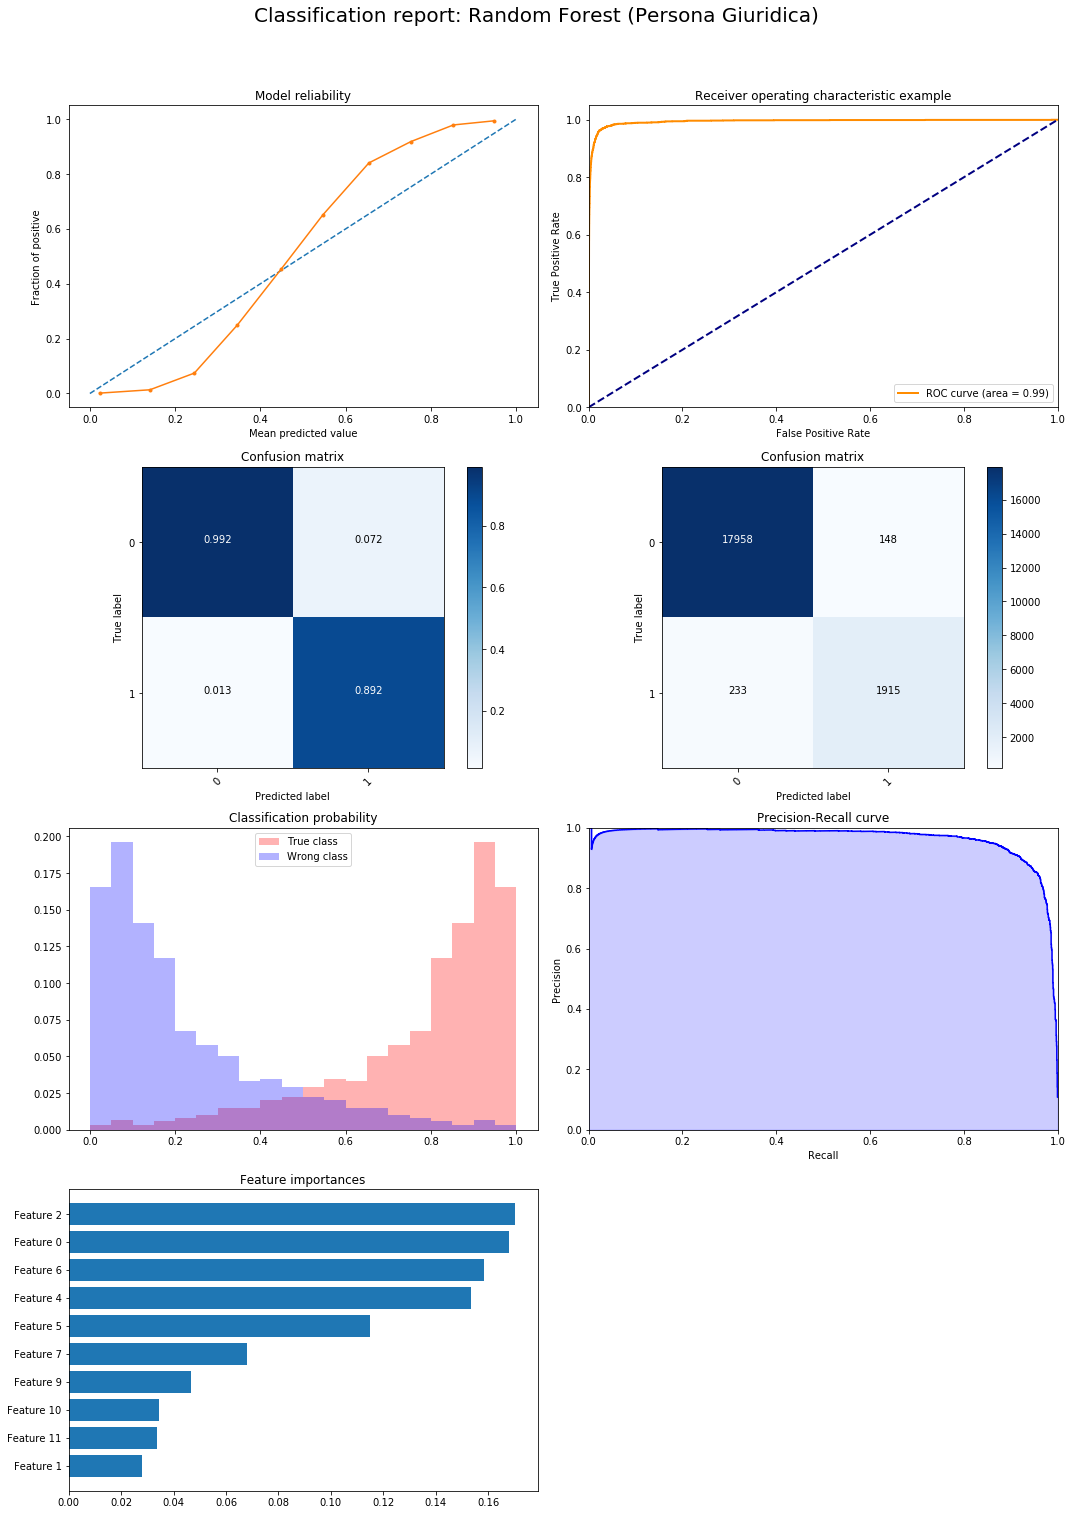

In [38]:
plot_report('Random Forest (Persona Giuridica)', model, X_test, y_test_classifier)

# Regressor

In [39]:
%%time
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=500, min_samples_split=2, min_samples_leaf=2, n_jobs=-1, random_state=0,)

model=train_model('regressor_random_forest_pg'
            , model = model
            , X=X_train, y=y_train_regressor
            , save=True)

Save model to: regressor_random_forest_pg_20191105.joblib
CPU times: user 4min 20s, sys: 1.72 s, total: 4min 22s
Wall time: 5min 4s


In [40]:
print('R2 on test sample: %.3f' % model.score(X_test, y_test_regressor))
y_pred = model.predict(X_test)
print('MSE on test sample: %.3f' % mean_squared_error(y_test_regressor, y_pred))

R2 on test sample: 0.787
MSE on test sample: 0.003


In [41]:
cross_validate_model(model, X_train, y_train_regressor, cv=3,
                     scoring=['r2', 'neg_mean_squared_error'])

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  5.2min finished


,Neg mean squared error,R2
error,0.000193,0.016372
value,-0.004406,0.673543


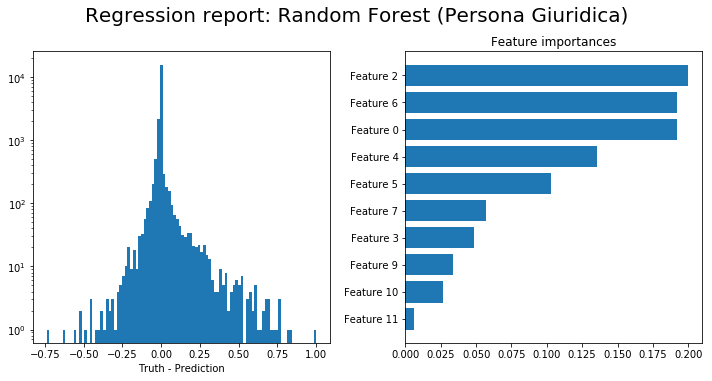

In [42]:
reg_plot_report('Random Forest (Persona Giuridica)', model, X_test, y_test_regressor)

# Summary
Following the recommendation given in the summary of *modeling_and_performance_part1.ipynb*, in this notebook I divided the sample by type of customers (*Persona Fisica*, *Persona Giuridica* and *Cointestazione*). The Peason's correlation coefficients showed that an additional feature ('IMP_FAR') should be considered for customers of type *Persona Fisica* since its predictive power is not highlighted when considering the sample as a whole.

I then trained separated models for different customer type and found some improvements in both the classification and the regression tasks.

Dividing the dataset over customer types decrease the size of the train/test samples, however the number of data points remain adequate to train Random Forest models.

Customer Type     | Train  | Test  |
------------------|--------|-------|
All customers     | 174693 | 43674 |
Persona Fisica    |  58988 | 14748 |
Persona Giuridica |  81012 | 20254 |
Cointestazione    |  34692 |  8673 |

The models performance have been found to be as follow:

(the values within parenthesis represent the performance measured on the test sample)

Customer Type     | F1          | P           | R           | ROC  | R2          | MSE           | 
------------------|-------------|-------------|-------------|------|-------------|---------------|
All customers     | 0.85 (0.91) | 0.89 (0.93) | 0.81 (0.89) | 0.98 | 0.66 (0.78) | 0.005 (0.003) |
Persona Fisica    | 0.90 (0.91) | 0.91 (0.93) | 0.88 (0.94) | 0.99 | 0.73 (0.83) | 0.004 (0.002) | 
Persona Giuridica | 0.87 (0.93) | 0.91 (0.94) | 0.84 (0.92) | 0.99 | 0.72 (0.83) | 0.004 (0.002) |
Cointestazione    | 0.89 (0.93) | 0.91 (0.94) | 0.86 (0.92) | 0.98 | 0.70 (0.82) | 0.005 (0.003) |

Training separated models for different customer type improve the performance by 3-5% (F1) for the classification task and by 5-7% for the regression task. 

These separate models will then be used to rank NPL on the prediction dataset in predict_and_rank.ipynb notebook.